In [14]:
import numpy as np
import scipy
import h5py
from PIL import Image
from scipy import ndimage
from lr_utils import load_dataset
trsetxorig, trsety, testxorig, testy, classes = load_dataset()

In [193]:
trsetxorig[6].shape

(64, 64, 3)

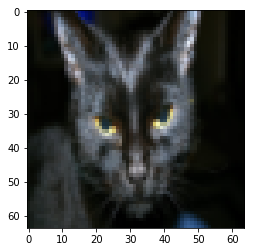

In [21]:
index = 25
plt.imshow(trsetxorig[index])

In [39]:
np.shape(trsetxorig), np.shape(trsety), np.shape(testxorig), np.shape(testy)

((209, 64, 64, 3), (1, 209), (50, 64, 64, 3), (1, 50))

In [28]:
trsety[0][index]

1

In [36]:
classes
trsety[0][index]
classes[trsety[0][index]].decode('utf-8')

'cat'

In [40]:
m_train = trsety.shape[1]
m_test = testy.shape[1]
num_px = trsetxorig.shape[1]

In [48]:
print("# of tr eg.: m_train = " + str(m_train))
print("# of test eg.: m_test = " + str(m_test))
print("Height&Width of each image: " + str(num_px))
print("------------------------------------")
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(trsetxorig.shape))
print ("train_set_y shape: " + str(trsety.shape))
print ("test_set_x shape: " + str(testxorig.shape))
print ("test_set_y shape: " + str(testy.shape))

# of tr eg.: m_train = 209
# of test eg.: m_test = 50
Height&Width of each image: 64
------------------------------------
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


---

### 1) Flatten: convert X into single vector
- Original: (#ofPX, #ofPX, 3)
- Flattend: (#ofPX * #ofPX * 3)
- X_flatten = X.reshape(X.shape[0], -1).T

- Number of data

In [148]:
flattenX.shape

(12288, 209)

In [133]:
NumOfData = trsetxorig.shape[0]
flattenX = trsetxorig.reshape(NumOfData, -1).T

NumOfData = testxorig.shape[0]
flattenX_test = testxorig.reshape(NumOfData, -1).T

flattenX.shape

(12288, 209)

### 2) scaling

In [134]:
train_x = flattenX / 255.
test_x = flattenX_test / 255.

In [135]:
train_x.shape, trsety.shape

((12288, 209), (1, 209))

---

### 3) building a Neural Network
- Loop
    - Calculate current loss (forward propagation)
        - $L(a^{(i)}, y^{(i)}) = -y^{(i)} \log{a^{(i)}}
        - (1-y^{(i)}) \log(1 - a^{(i)})$
    - Calculate gradient (backward propagation)

### 3.1) sigmoid

In [71]:
def sigmoid(z):
    s = 1 / (1 + np.exp(-z))
    return s

# test code
z = np.array([[1,2],
             [2,3]])
sigmoid(z)

array([[0.73105858, 0.88079708],
       [0.88079708, 0.95257413]])

### 3.2) Initialize params

In [150]:
def initialize_with_zero(dim):
    """
    return 
    - w: zero vector(dim, 1)
    - b: 0 
    """
    w = np.zeros(shape=(dim, 1))
    b = 0
    
    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b ,int))
    
    return w, b

# test code
dim = train_x.shape[0]
w, b = initialize_with_zero(dim)
w[:5], b

(array([[0.],
        [0.],
        [0.],
        [0.],
        [0.]]), 0)

### 3.3) Forward and Backward Propagation
- $X \rightarrow Z \rightarrow A$

In [137]:
w.shape

(209, 1)

In [138]:
train_x.shape

(12288, 209)

In [154]:
def propagate(w, b, X, Y):
    dim = X.shape[1]
    m = dim
    Z = np.dot(w.T, X) + b
    A = sigmoid(Z)
    loss = -Y * np.log(A) -(1 - Y) * np.log(1 - A)
    cost = (1 / m) * np.sum(loss)
    
    dw = (1 / m) * np.dot(X, (A - Y).T)
    db = (1 / m) * np.sum(A - Y)
    
    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {"dw": dw,
            "db": db}
    
    return grads, cost

# test code
grads, cost = propagate(w, b, train_x, trsety)
print("grads: ", grads)
print("cost: ", cost)

grads:  {'dw': array([[0.04720893],
       [0.06299841],
       [0.04923539],
       ...,
       [0.05074585],
       [0.0621259 ],
       [0.03245145]]), 'db': 0.15550239234449761}
cost:  0.6931471805599453


## 3.3) optimization

In [84]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost=False):
    costs = []
    for i in range(num_iterations):
        grads, cost = propagate(w, b, X, Y)
        
        dw = grads['dw']
        db = grads['db']
        
        w = w - learning_rate * dw
        b = b - learning_rate * db
        
        if i % 100 == 0:
            costs.append(cost)
        
        if print_cost and i % 100 == 0:
            print("Cost: {c} (after {i}th iteration)".format(c=cost, i=i))
    
    params = {'w': w,
             'b': b}
    grads = {'dw': dw,
            'db': db}
    
    return params, grads, costs

In [90]:
params, grads, costs = optimize(w, b, X, Y, num_iterations=200, learning_rate=0.009, print_cost=True)
print(params)
print("-------------------------------------------------")
print(grads)
print("-------------------------------------------------")
print(costs)

Cost: 6.000064773192205 (after 0th iteration)
Cost: 1.4313999565615696 (after 100th iteration)
{'w': array([[-0.25752876],
       [-0.35717757]]), 'b': 1.4501755960194689}
-------------------------------------------------
{'dw': array([[0.14547118],
       [0.05636579]]), 'db': -0.04455269818367541}
-------------------------------------------------
[6.000064773192205, 1.4313999565615696]


## 3.4) prediction

In [93]:
def predict(w, b, X):
    dim = X.shape[1]
    m = dim
    Y_pred = np.zeros((1, m))
    w = w.reshape(X.shape[0], 1)
    
    Z = np.dot(w.T, X) + b
    A = sigmoid(Z)
    
    for i in range(A.shape[1]):
        Y_pred[0, i] = 1 if A[0, i] > 0.5 else 0
    
    assert(Y_pred.shape == (1, m))

    return Y_pred

In [155]:
print('w: ', w)
print('b: ', b)
print('X: ', X)

w:  [[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
b:  0
X:  [[1 2]
 [3 4]]


In [157]:
predict(w, b, train_x)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.]])

## 4) final Model

In [175]:
def model(X_train, Y_train, X_test, Y_test, num_iteration=2000, learning_rate=0.5, print_cost=False):
    
    NumOfData = X_train.shape[0]
    
    w, b = initialize_with_zero(NumOfData)
    params, grads, costs = optimize(w, b, X_train, Y_train, num_iteration, learning_rate, print_cost)
    
    w = params['w']
    b = params['b']
    
    Y_pred_test = predict(w, b, X_test)
    Y_pred_train = predict(w, b, X_train)
    
    # Error
    train_error = np.abs(Y_pred_train - Y_train)
    test_error = np.abs(Y_pred_test - Y_test)
    print("train accuracy: {}".format(100 - np.mean(train_error)*100))
    print("test accuracy: {}".format(100 - np.mean(test_error)*100))
          
    d = {"costs": costs,
        "Y_prediction_test": Y_pred_test,
        "Y_prediction_training": Y_pred_train,
        "w": w,
        "b": b,
        "learning_rate": learning_rate,
        "num_iteration": num_iteration}
    
    return d

In [176]:
d = model(train_x, trsety, test_x, testy, num_iteration=2000, learning_rate = 0.005, print_cost = True)

Cost: 0.6931471805599453 (after 0th iteration)
Cost: 0.5845083636993087 (after 100th iteration)
Cost: 0.4669490409465546 (after 200th iteration)
Cost: 0.37600686694802077 (after 300th iteration)
Cost: 0.33146328932825114 (after 400th iteration)
Cost: 0.3032730674743829 (after 500th iteration)
Cost: 0.2798795865826048 (after 600th iteration)
Cost: 0.2600421369258757 (after 700th iteration)
Cost: 0.24294068467796615 (after 800th iteration)
Cost: 0.22800422256726066 (after 900th iteration)
Cost: 0.2148195137844964 (after 1000th iteration)
Cost: 0.20307819060644997 (after 1100th iteration)
Cost: 0.19254427716706857 (after 1200th iteration)
Cost: 0.18303333796883509 (after 1300th iteration)
Cost: 0.1743985943844888 (after 1400th iteration)
Cost: 0.16652139705400335 (after 1500th iteration)
Cost: 0.15930451829756614 (after 1600th iteration)
Cost: 0.1526673247129651 (after 1700th iteration)
Cost: 0.1465422350398234 (after 1800th iteration)
Cost: 0.14087207570310165 (after 1900th iteration)
tr

In [187]:
# 틀린 문제
criteria = d['Y_prediction_test'] - testy == -1
np.where(criteria)[1]

array([ 6, 10, 11, 18, 19, 28, 30, 33, 41, 46])

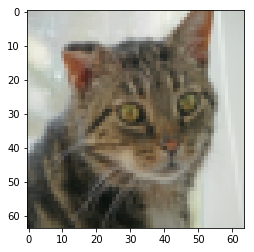

In [211]:
# revert
idx = 33
plt.imshow(test_x[:, idx].reshape((num_px, num_px, 3)))

In [ ]:
def model(X_train, Y_train, X_test, Y_test, num_iterations=2000, learning_rate=0.5, print_cost=False):
    """
    Builds the logistic regression model by calling the function you've implemented previously
    
    Arguments:
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """
    
    ### START CODE HERE ###
    # initialize parameters with zeros (≈ 1 line of code)
    w, b = initialize_with_zeros(X_train.shape[0])

    # Gradient descent (≈ 1 line of code)
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    
    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]
    
    # Predict test/train set examples (≈ 2 lines of code)
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)

    ### END CODE HERE ###

    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

reference
- https://github.com/Kulbear/deep-learning-coursera